# Feature selection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)
%matplotlib inline

### load datasets

In [2]:
%store -r train_data_formodel
data = train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques

## configurations

* random_seed_state -> number, sets random state for model and for stratified splits 

In [3]:
random_seed_state = 42

### Recursive feature elimination with 3-fold cross-validation is done using Random Forest Classifiers 

In [4]:
my_rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state = random_seed_state)

In [5]:
my_rfc_selector = RFECV(estimator=my_rfc, step=1, cv=StratifiedKFold(3), verbose=2, scoring='f1_weighted')

### set X and y as features and target respectively

In [6]:
X = data[data.columns.values[9:-1]]
y = data['class']

### check dimensions of features and target are as expected

In [7]:
print(X.shape)
print(y.shape)

(1203, 53)
(1203,)


### do recursive feature elimination

In [8]:
selector = my_rfc_selector.fit(X, y)

Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 fe

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 featu

### identify number of features with the best f1 score


In [9]:
my_rfc_selector.ranking_
feat_ranks = pd.DataFrame(data = {'features': data.columns.values[9:-1], 'rfe ranking': my_rfc_selector.ranking_} )
feat_ranks.sort_values(by = 'rfe ranking', inplace=True)
best_number_feats_rfe = my_rfc_selector.n_features_

In [16]:
best_number_feats_rfe = 30

### features ranked by their recursive feature elimination scores

In [17]:
feat_ranks

,features,rfe ranking
26,Zr90,1
37,Nd146,1
33,Ba137,1
24,Sr88,1
21,Ge72,1
20,Ga69,1
15,Fe56,1
13,Cr52,1
12,V51,1
10,Sc45,1


### select best features 

In [18]:
best_feats = list(feat_ranks['features'][0: best_number_feats_rfe])

### weighted-f1 score is plotted against number of features

In [19]:
RFCV_df = pd.DataFrame(data = {'no_features' : range(1, len(my_rfc_selector.grid_scores_) + 1), 'scores': my_rfc_selector.grid_scores_})

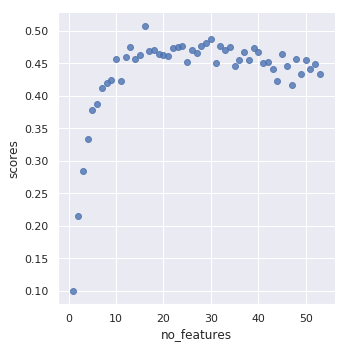

In [20]:
sns.set(rc={'figure.figsize':(15.7,15.27)})
sns.lmplot(data = RFCV_df, x = 'no_features', y = 'scores', fit_reg=False)

### the names of the best features and all features in order of recursive feature elimination rank are stored 

In [21]:
%store best_feats

Stored 'best_feats' (list)
